In [2]:
!pwd
!which python
!pip freeze | grep -E 'flax|jax|orbax|optax'

/Users/tristantorchet/Desktop/Code/VSCode/LearningJAX/Flax


/opt/homebrew/Cellar/python@3.12/3.12.4/Frameworks/Python.framework/Versions/3.12/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/Users/tristantorchet/Desktop/Code/VSCode/LearningJAX/.venv/bin/python
flax==0.8.0
jax==0.4.25
jaxlib==0.4.25
jaxtyping==0.2.36
optax==0.1.8
orbax-checkpoint==0.5.0


In [3]:
import jax
import numpy as np
import torch
from jax import numpy as jnp
from torch.utils.data import TensorDataset
from tqdm import tqdm
import torchvision
import torchvision.transforms as transforms
from flax import linen as nn
from jax.nn.initializers import lecun_normal
from typing import Any, Tuple, Sequence, Optional

jnp.set_printoptions(precision=3, suppress=True)


In [4]:
# WARNING: this code is from QSSM project and won't be updated 
def create_mnist_classification_dataset(bsz=128, root="./data"):
    print("[*] Generating MNIST Classification Dataset...")

    # Constants
    SEQ_LENGTH, N_CLASSES, IN_DIM = 784, 10, 1
    tf = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize(mean=0.5, std=0.5),
            transforms.Lambda(lambda x: x.view(IN_DIM, SEQ_LENGTH).t()),
        ]
    )

    train = torchvision.datasets.MNIST(
        root, train=True, download=True, transform=tf
    )
    test = torchvision.datasets.MNIST(
        root, train=False, download=True, transform=tf
    )

    # Return data loaders, with the provided batch size
    trainloader = torch.utils.data.DataLoader(
        train, batch_size=bsz, shuffle=True
    )
    testloader = torch.utils.data.DataLoader(
        test, batch_size=bsz, shuffle=False
    )

    return trainloader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM


In [5]:
trainloader, testloader, N_CLASSES, SEQ_LENGTH, IN_DIM = create_mnist_classification_dataset(root="../data")

[*] Generating MNIST Classification Dataset...


In [6]:
batch_x, batch_y = next(iter(testloader))
print(batch_x.shape, batch_y.shape)

# the last dimension is 1, we need to remove it
batch_x = batch_x.squeeze(-1)
print(batch_x.shape)


torch.Size([128, 784, 1]) torch.Size([128])
torch.Size([128, 784])


In [7]:
class MLP(nn.Module):
    features: Sequence[int]

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=self.features[0], name="hidden")(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.features[-1], name="output")(x)
        return x

# Instantiate the model
model = MLP(features=[784, 10])

# Initialize the model
key = jax.random.PRNGKey(0)
x = jnp.ones((1, 784))  # Example input of shape (1, 784)
params = model.init(key, x)  # Initialize parameters

# Apply the model to input x
output = model.apply(params, x)

# Apply the cross-entropy loss
loss = jax.nn.log_softmax(output)
print("Loss:", loss)
print("Probabilities:", jnp.exp(loss))




Loss: [[-2.832 -2.556 -3.016 -3.787 -2.875 -2.965 -1.184 -1.611 -2.074 -2.943]]
Probabilities: [[0.059 0.078 0.049 0.023 0.056 0.052 0.306 0.2   0.126 0.053]]


In [122]:
def recurrent_mapping(tree, level=1):
    suffix = '----' * level + ' ' if level > 0 else ''
    for k, v in tree.items():
        if isinstance(v, dict):
            print(f'{suffix}{k}')
            recurrent_mapping(v, level + 1)
        else: 
            print(f'{suffix}{k} -- is leaf')
recurrent_mapping(params, level=0)

params
---- hidden
-------- kernel -- is leaf
-------- bias -- is leaf
---- output
-------- kernel -- is leaf
-------- bias -- is leaf


In [123]:
mapped_fn = lambda x: x.keys() if isinstance(x, dict) else x
jax.tree_util.tree_map(lambda x: x.shape, params)

{'params': {'hidden': {'bias': (784,), 'kernel': (784, 784)},
  'output': {'bias': (10,), 'kernel': (784, 10)}}}

In [134]:
# recover the name of the parameters
def recover_structure(tree):
    for leaf in jax.tree_util.tree_flatten_with_path(tree)[0]:
        path = ''
        for elem in leaf[:-1]:
            for name in elem:
                path += f'.{name.key}'
    print(path)


recover_structure(params)


.params.output.kernel


In [125]:
jax.tree_util.tree_flatten_with_path(params)[0][3][0]

(DictKey(key='params'), DictKey(key='output'), DictKey(key='kernel'))

In [126]:
jax.tree_util.tree_flatten_with_path(params)[0][0][0][0].key

'params'

In [127]:
len(jax.tree_util.tree_flatten(params)[0])

4

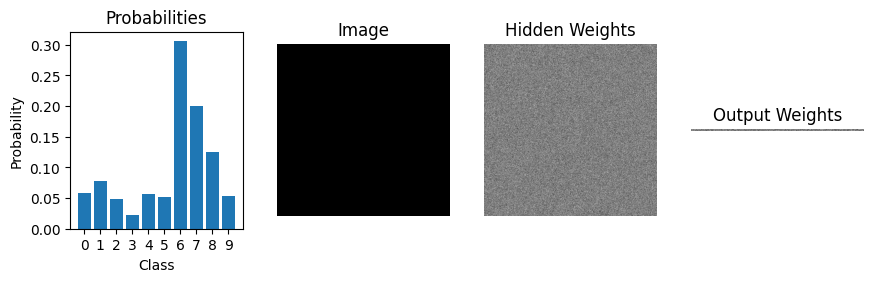

In [101]:
# Plot the probabilities and the image next to it
import matplotlib.pyplot as plt
px = 1/ plt.rcParams['figure.dpi']
n_rows = 1
n_cols = 4
fig, axs = plt.subplots(n_rows, n_cols, figsize=(256*n_cols*px, 256*n_rows*px))
axs[0].bar(range(10), jnp.exp(loss).squeeze())
axs[0].set_xticks(range(10))
axs[0].set_title("Probabilities")
axs[0].set_ylabel("Probability")
axs[0].set_xlabel("Class")
axs[1].imshow(x.squeeze().reshape(28, 28), cmap="gray")
axs[1].set_title("Image")
axs[1].axis("off")
weights_hidden = params['params']['hidden']['kernel']
axs[2].imshow(weights_hidden.T, cmap="gray")
axs[2].set_title("Hidden Weights")
axs[2].axis("off")
weights_output = params['params']['output']['kernel']
axs[3].imshow(weights_output.T, cmap="gray")
axs[3].set_title("Output Weights")
axs[3].axis("off")

plt.show()